# Деревья решений решают проблемы
__Суммарное количество баллов: 10__

Вы уже знакомы с классификацией методом KNN. В этом задании предстоит реализовать другой метод классификации - дерево решений. 

Одной из его особенностей является возможность объяснить в человекочитаемой форме, почему мы отнесли объект к определенному классу. Эта особенность позволяет использовать деревья решений для создания систем, которые могут подсказывать специалистам, на что именно стоит обратить внимание при принятии решений.

In [2]:
from sklearn.datasets import make_blobs, make_moons
import numpy as np
import pandas
import random
import matplotlib.pyplot as plt
import matplotlib
import csv

### Задание 1 (2 балла)
Во время построения дерева решений нам потребуется определить, какой из предикатов лучше всего разбивает обучающую выборку. Есть два критерия, которые позволяют это сделать: критерий Джини и энтропийный критерий. Первый для подсчета информативности разбиения использует коэффициент Джини, второй - энтропию. Реализуйте подсчет этих коэффициентов, а так же подсчет информативности разбиения. 

#### Описание функций
`gini(x)` считает коэффициент Джини для массива меток

`entropy(x)` считает энтропию для массива меток

`gain(left_y, right_y, criterion)` считает информативность разбиения массива меток на левую `left_y` и правую `right_y` части при помощи `criterion`, который задается функцией (не строкой).

In [3]:
def gini(x):
    if len(x) == 0:
        return 0
    ones = 0
    zeros = 0
    size = len(x)
    for i in range(size):
        if x[i] == 1:
            ones += 1
        if x[i] == 0:
            zeros += 1
    gini = ones * zeros / size ** 2
    return gini

def entropy(x):
    ones = 0
    zeros = 0
    size = len(x)
    if size == 0:
        return 0

    for i in range(size):
        if x[i] == 1:
            ones += 1
        if x[i] == 0:
            zeros += 1

    if ones == 0:
        entropy = - zeros / size * math.log(zeros / size, 2)
    elif zeros == 0:
        entropy = - ones / size * math.log(ones / size, 2)
    else:
        entropy = - zeros / size * math.log(zeros / size, 2) - ones / size * math.log(ones / size, 2)
    return entropy


def gain(left_y, right_y, criterion):
    size = len(left_y) + len(right_y)
    return len(left_y) * criterion(left_y) / size + len(right_y) * criterion(right_y) / size

### Задание 2 (2 балла)
Деревья решений имеют хорошую интерпретируемость, т.к. позволяют не только предсказать класс, но и объяснить, почему мы предсказали именно его. Например, мы можем его нарисовать. Чтобы сделать это, нам необходимо знать, как оно устроено внутри. Реализуйте классы, которые будут задавать структуру дерева. 

#### DecisionTreeLeaf
Поля:
1. `y` должно содержать класс, который встречается чаще всего среди элементов листа дерева

#### DecisionTreeNode
В данной домашней работе мы ограничемся порядковыми и количественными признаками, поэтому достаточно хранить измерение и значение признака, по которому разбиваем обучающую выборку.

Поля:
1. `split_dim` измерение, по которому разбиваем выборку
2. `split_value` значение, по которому разбираем выборку
3. `left` поддерево, отвечающее за случай `x[split_dim] < split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`
4. `right` поддерево, отвечающее за случай `x[split_dim] >= split_value`. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

__Интерфейс классов можно и нужно менять при необходимости__ (например, для вычисления вероятности в следующем задании)

In [4]:
class DecisionTreeLeaf:
    def __init__(self, y):
        self.y = y

class DecisionTreeNode:
    def __init__(self, split_dim, split_value):
        self.split_dim = split_dim
        self.split_value = split_value
        self.left = None
        self.right = None


### Задание 3 (6 баллов)
Теперь перейдем к самому дереву решений. Реализуйте класс `DecisionTreeClassifier`.

#### Описание методов
`fit(X, y)` строит дерево решений по обучающей выборке.

`predict_proba(X)` для каждого элемента из `X` возвращает словарь `dict`, состоящий из пар `(класс, вероятность)`. Вероятности классов в листе можно определить через количество объектов соответствующего класса в листе. 

#### Описание параметров конструктора
`criterion="gini"` - задает критерий, который будет использоваться при построении дерева. Возможные значения: `"gini"`, `"entropy"`.

`max_depth=None` - ограничение глубины дерева. Если `None` - глубина не ограничена

`min_samples_leaf=1` - минимальное количество элементов в каждом листе дерева.

#### Описание полей
`root` - корень дерева. Может быть `DecisionTreeNode` или `DecisionTreeLeaf`

In [5]:
class DecisionTreeClassifier:
    def __init__(self, criterion=gini, max_depth=None, min_samples_leaf=1):
        self.root = None
        self.criterion = criterion
        self.max_depth = max_depth
        self.min_samples_leaf = min_samples_leaf

    def fit(self, X, y):
        self.root = self.create_tree(1, X, y, self.root)

    def predict_proba(self, X):
        p = []
        for line in X_test:
            p.append((self.get_proba(self.get_leaf(line, self.root))))
        return p

    def predict(self, X):
        proba = self.predict_proba(X)
        return [max(p.keys(), key=lambda k: p[k]) for p in proba]

    def get_leaf(self, line, root):
        if isinstance(root, DecisionTreeNode):
           if line[root.split_dim] < root.split_value:
                p = self.get_leaf(line, root.left)
           else:
                p = self.get_leaf(line, root.right)
        elif isinstance(root, DecisionTreeLeaf):
            return root.y
        return p
    
    def get_proba(self, x):
        ones = 0
        size = len(x)
        if size == 0:
             return {0: 0, 0: 0}
        for i in x:
            if i == 1:
                ones += 1
        
        return {0: (size - ones) / size, 1: ones / size}

    def create_tree(self, depth, values, y, root):
        left, right, left_y, right_y, dim, atribute, score = self.best_split(values, y)
        root = DecisionTreeNode(dim, atribute)
        
        if len(left) < self.min_samples_leaf or isinstance(self.max_depth, int) and depth >= self.max_depth:
            root.left = DecisionTreeLeaf(left_y)
        else:
            root.left = self.create_tree(depth+1, left, left_y, root.left)

        if len(right) < self.min_samples_leaf or isinstance(self.max_depth, int) and depth >= self.max_depth:
            root.right = DecisionTreeLeaf(right_y)
        else:
           root = self.create_tree(depth+1, right, right_y, root.right)

        return root
    
    def split(self, values, atribute, dim, y):
        left = []
        right = []
        left_y = []
        right_y = []

        for i in range(len(values)):
            if values[i][dim] < atribute:
                left.append(values[i])
                left_y.append(y[i])
            else:
                right.append(values[i])
                right_y.append(y[i])

        return left, right, left_y, right_y

    def best_split(self, values, y):
        best_dim = 0
        best_atribute = 0
        best_left = []
        best_right = []
        best_score = 999999
        best_left_y = []
        best_right_y = []

        for j in range(len(values[0])):
            for i in range(len(values)):
                left, right, left_y, right_y = self.split(values, values[i][j], j, y)
                score = gain(left_y, right_y, self.criterion)
                if score < best_score:
                    best_score = score
                    best_dim = j
                    best_atribute = values[i][j]
                    best_left = left
                    best_right = right
                    best_left_y = left_y
                    best_right_y = right_y


        return best_left, best_right, best_left_y, best_right_y, best_dim, best_atribute, best_score

Построенное дерево можно нарисовать. Метод `draw_tree` рисует дерево и сохраняет его в указанный файл.

In [6]:
def tree_depth(tree_root):
    if isinstance(tree_root, DecisionTreeNode):
        return max(tree_depth(tree_root.left), tree_depth(tree_root.right)) + 1
    else:
        return 1

def draw_tree_rec(tree_root, x_left, x_right, y):
    x_center = (x_right - x_left) / 2 + x_left
    if isinstance(tree_root, DecisionTreeNode):
        x_center = (x_right - x_left) / 2 + x_left
        x = draw_tree_rec(tree_root.left, x_left, x_center, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        x = draw_tree_rec(tree_root.right, x_center, x_right, y - 1)
        plt.plot((x_center, x), (y - 0.1, y - 0.9), c=(0, 0, 0))
        plt.text(x_center, y, "x[%i] < %f" % (tree_root.split_dim, tree_root.split_value),
                horizontalalignment='center')
    else:
        plt.text(x_center, y, str(tree_root.y),
                horizontalalignment='center')
    return x_center

def draw_tree(tree, save_path=None):
    td = tree_depth(tree.root)
    plt.figure(figsize=(0.33 * 2 ** td, 2 * td))
    plt.xlim(-1, 1)
    plt.ylim(0.95, td + 0.05)
    plt.axis('off')
    draw_tree_rec(tree.root, -1, 1, td)
    plt.tight_layout()
    if save_path is not None:
        plt.savefig(save_path)
    plt.show()

Для двумерного набора данных дерево можно отобразить на плоскости с данными. Кроме того, как и для любого классификатора, для него можно построить roc-кривую

In [7]:
def plot_roc_curve(y_test, p_pred):
    positive_samples = sum(1 for y in y_test if y == 0)
    tpr = []
    fpr = []
    for w in np.arange(-0.01, 1.02, 0.01):
        y_pred = [(0 if p.get(0, 0) > w else 1) for p in p_pred]
        tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
        fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
    plt.figure(figsize = (7, 7))
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

def rectangle_bounds(bounds):
    return ((bounds[0][0], bounds[0][0], bounds[0][1], bounds[0][1]), 
            (bounds[1][0], bounds[1][1], bounds[1][1], bounds[1][0]))

def plot_2d_tree(tree_root, bounds, colors):
    if isinstance(tree_root, DecisionTreeNode):
        if tree_root.split_dim:
            plot_2d_tree(tree_root.left, [bounds[0], [bounds[1][0], tree_root.split_value]], colors)
            plot_2d_tree(tree_root.right, [bounds[0], [tree_root.split_value, bounds[1][1]]], colors)
            plt.plot(bounds[0], (tree_root.split_value, tree_root.split_value), c=(0, 0, 0))
        else:
            plot_2d_tree(tree_root.left, [[bounds[0][0], tree_root.split_value], bounds[1]], colors)
            plot_2d_tree(tree_root.right, [[tree_root.split_value, bounds[0][1]], bounds[1]], colors)
            plt.plot((tree_root.split_value, tree_root.split_value), bounds[1], c=(0, 0, 0))
    else:
        x, y = rectangle_bounds(bounds)
        plt.fill(x, y, c=colors[tree_root.y] + [0.2])

def plot_2d(tree, X, y):
    plt.figure(figsize=(9, 9))
    colors = dict((c, list(np.random.random(3))) for c in np.unique(y))
    bounds = list(zip(np.min(X, axis=0), np.max(X, axis=0)))
    plt.xlim(*bounds[0])
    plt.ylim(*bounds[1])
    plot_2d_tree(tree.root, list(zip(np.min(X, axis=0), np.max(X, axis=0))), colors)
    for c in np.unique(y):
        plt.scatter(X[y==c, 0], X[y==c, 1], c=[colors[c]], label=c)
    plt.legend()
    plt.tight_layout()
    plt.show()

Протестируйте решение на данных cancer и spam.

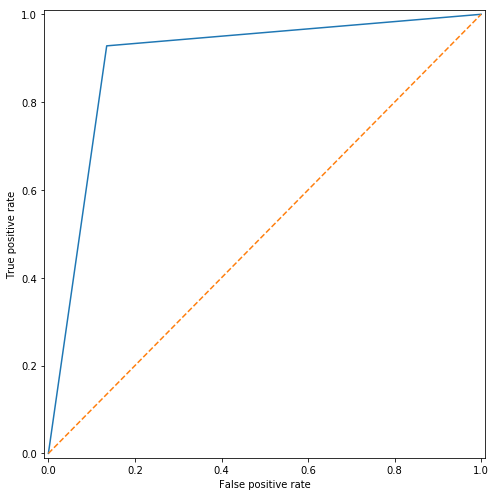

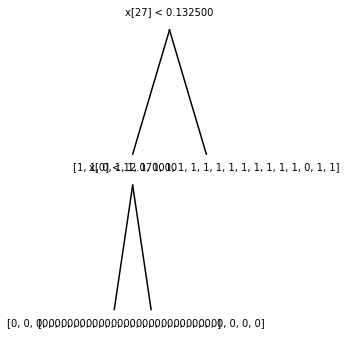

In [24]:
def read_cancer_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    for row in reader:
        list = [[]]
        label = 0
        for col in row:
            if col == 'label':
                break
            if col == 'M':
                label = 1
            if col != 'M' and col != 'B':
               list[0].append(float(col))

        if y[0].size == 0:
            y = np.array([label])
        else:
            y = np.append(y, [label])
        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

def read_spam_dataset(path_to_csv):
    # Возвращает пару из X и y. X - массив векторов. y - соответствующие векторам метки
    f = open(path_to_csv, 'r')
    X = np.array([[]])
    y = np.array([[]])
    reader = csv.reader(f)
    k = 0
    for row in reader:
        if k == 0:
            k = 1
            continue
        list = [[]]
        for i in range(len(row)):
            if i != len(row)-1:
                list[0].append(float(row[i]))
            else:
                if y[0].size == 0:
                    y = np.array([int(row[i])])
                else:
                    y = np.append(y, [int(row[i])])

        if X[0].size == 0:
            X = np.array(list)
        else:
            X = np.append(X, list, axis = 0)

    f.close()
    return X[:][:], y[1:]

def train_test_split(X, y, ratio):
    # Возвращает X_train, y_train, X_test, y_test
    # X_train и X_test - массив векторов - две части массива X, разделенного в состветсви с коэффициентом ratio
    # y_train и y_test - соответствующие X_train и X_test метки классов
    X_train = np.array([[]])
    X_test = np.array([[]])
    y_train = np.array([])
    y_test = np.array([])
    trainlist = []
    testlist = []
    train = int(ratio*len(y))

    for i in range(train):
        tr = random.randint(0, len(y)-1)
        while tr in trainlist:
            tr = random.randint(0, len(y)-1)

        trainlist.append(tr)

    for i in range(0, len(y)):
        if i not in trainlist:
            testlist.append(i)

    X_train = X[trainlist][:]
    X_test = X[testlist][:]
    y_train = y[trainlist]
    y_test = y[testlist]

    return X_train, y_train, X_test, y_test


X, y = read_cancer_dataset('cancer.csv')
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.1)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train)
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)

Возможно, надо доработать

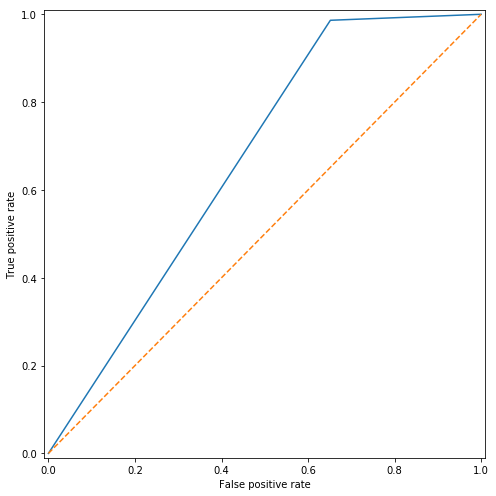

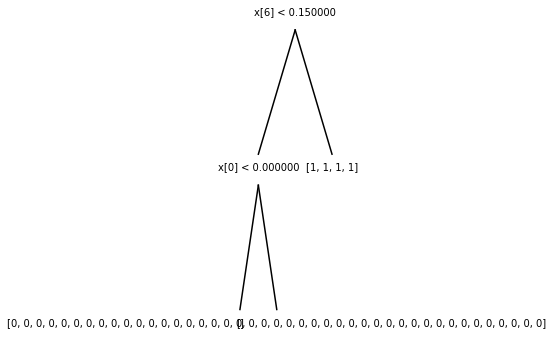

In [29]:
X, y = read_spam_dataset('spam.csv')
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.7)
tree = DecisionTreeClassifier(max_depth=5, min_samples_leaf=30)
tree.fit(X_train, y_train) # это занимает 15 минут
plot_roc_curve(y_test, tree.predict_proba(X_test))
draw_tree(tree)